<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/ResNet_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence

In [0]:
import tensorflow_datasets as tfds

In [16]:
####### JL: vanessa path
# root      = '/global/cscratch1/sd/vboehm'
# data_path = os.path.join(root,'Datasets/Gaussian_Kappa/')
# model_path= os.path.join(root,'Models/Gaussian_Kappa')

####### JL path

from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/TF')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
S8_gen= lambda params: sqrt(params.T[0]/0.3)*params.T[1]

In [0]:
VERSION = tfds.core.Version('0.1.0')
data_set, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

In [0]:
DATASET_SIZE = info.splits['train'].num_examples

In [8]:
print (data_path)
print (DATASET_SIZE)

/content/drive/My Drive/tensorflow_datasets/
20000


tf.Tensor([0.16992588 0.7251126 ], shape=(2,), dtype=float32)


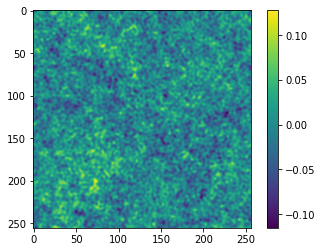

In [9]:
for example in data_set.take(1):  # Only take a single example
    kappa_map, params = example["map"], example["params"]
    imshow(np.squeeze(kappa_map))
    print(params)
    colorbar()

In [0]:
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    return x, y

def whiten(x,y):
    mean = tf.reduce_mean(x, axis=[1,2])
    print(mean.shape)
    std  = tf.math.reduce_std(x, axis=[1,2])
    print(std.shape)
    x    = (x-mean)/std
    x    = tf.expand_dims(x,-1)   
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[128,128])
    return x, y

In [11]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = data_set
full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset= full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset  = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print (train_size, val_size, test_size)

14000 3000 3000


In [0]:
train_dataset = train_dataset.batch(32).shuffle(1000)
train_dataset = train_dataset.map(redefine)
train_dataset = train_dataset.map(downsample)
train_dataset = train_dataset.repeat()

In [0]:
val_dataset = val_dataset.batch(64).shuffle(1000)
val_dataset = val_dataset.map(redefine)
val_dataset = val_dataset.map(downsample)
val_dataset = val_dataset.repeat()

In [0]:
test_dataset = test_dataset.map(redefine)
test_dataset = test_dataset.map(downsample).batch(256)

In [17]:
truth = list(test_dataset.as_numpy_iterator()) 
params_input = np.array([idata[1] for idata in truth])
params_input = concatenate(params_input, axis=0)
print (params_input.shape)

(3000, 2)


In [0]:
def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

In [0]:
def non_res_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

In [0]:
inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 5, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
num_res_net_blocks = 3
for i in range(num_res_net_blocks):
    x = res_net_block(x, 64, 3)
x = layers.Conv2D(64, 2, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2)(x)

res_net_model = keras.Model(inputs, outputs)

In [21]:
res_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 122, 122, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 61, 61, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
checkpoint_file = os.path.join(model_path+'/weights.{epoch:02d}-{val_loss:.3f}.hdf5')
ckpt_callback   = keras.callbacks.ModelCheckpoint(filepath=checkpoint_file, monitor='val_loss')
hists = []

In [0]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    try:
        return max(paths, key=os.path.getctime)
    except:
        return None

In [24]:
latest_file=newest(model_path)
print(latest_file)

/content/drive/My Drive/models/TF/weights.01-0.01.hdf5


In [0]:
def loss_L2(y_true, y_pred):
  return np.sum((y_pred - y_true)**2)

In [26]:
callbacks     = [ckpt_callback]
if latest_file is None:
    res_net_model.compile(optimizer=keras.optimizers.Adam(),loss='mse')   
    # res_net_model.compile(optimizer=keras.optimizers.Adam(),loss=loss_L2,metrics=['mse','mse'])  
else:
    res_net_model = keras.models.load_model(latest_file)

In [27]:
history = res_net_model.fit(train_dataset, epochs=50, steps_per_epoch=562, 
                            validation_data=val_dataset, verbose=1, validation_steps=3, 
                            callbacks=callbacks)
hists.append(history)

Epoch 1/50
562/562 [==============================] - 45s 80ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 2/50
562/562 [==============================] - 43s 77ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 3/50
562/562 [==============================] - 43s 77ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 4/50
562/562 [==============================] - 52s 93ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 5/50
562/562 [==============================] - 42s 75ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 6/50
562/562 [==============================] - 43s 77ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 7/50
562/5

In [28]:
predictions = res_net_model.predict(test_dataset)
print (predictions.shape)

(3000, 2)


In [0]:
true_s8=S8_gen(params_input)
pred_s8=S8_gen(predictions)

Text(0, 0.5, 'predicted S8')

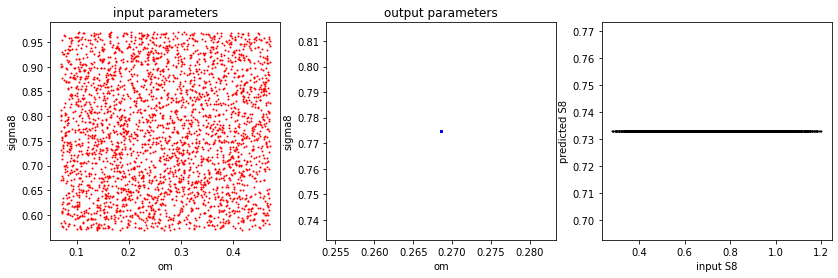

In [30]:
figure(figsize=(14,4))
subplot(1,3,1)
scatter(params_input.T[0], params_input.T[1],color='r',s=1)
title('input parameters')
xlabel('om')
ylabel('sigma8')
subplot(1,3,2)
scatter(predictions.T[0], predictions.T[1],color='b',s=1)
title('output parameters')
xlabel('om')
ylabel('sigma8')
subplot(1,3,3)
scatter(true_s8, pred_s8, s=1,color='k')
xlabel('input S8')
ylabel('predicted S8')

In [0]:
############ JL: what is this for?
# res_net_model.train_on_batch